In [2]:
!pip install tensorflow-datasets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
from tqdm import tqdm
import tensorflow_datasets as tfds

In [4]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.ZHVQZ5_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.ZHVQZ5_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [12]:
train_ds, valid_ds = ds['train'], ds['validation']

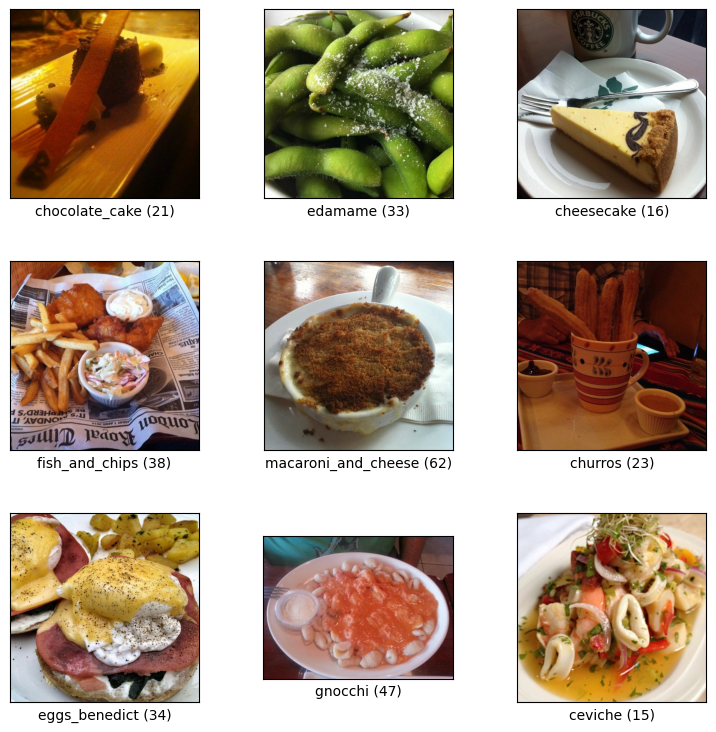

In [13]:
fig = tfds.show_examples(train_ds, ds_info)

In [16]:
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), # Change tf.in32 to tf.int32
                         tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32)) # Cast the label to tf.int32 as well for consistency
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), # Change tf.in32 to tf.int32
                         tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32)) # Cast the label to tf.int32 as well for consistency
)

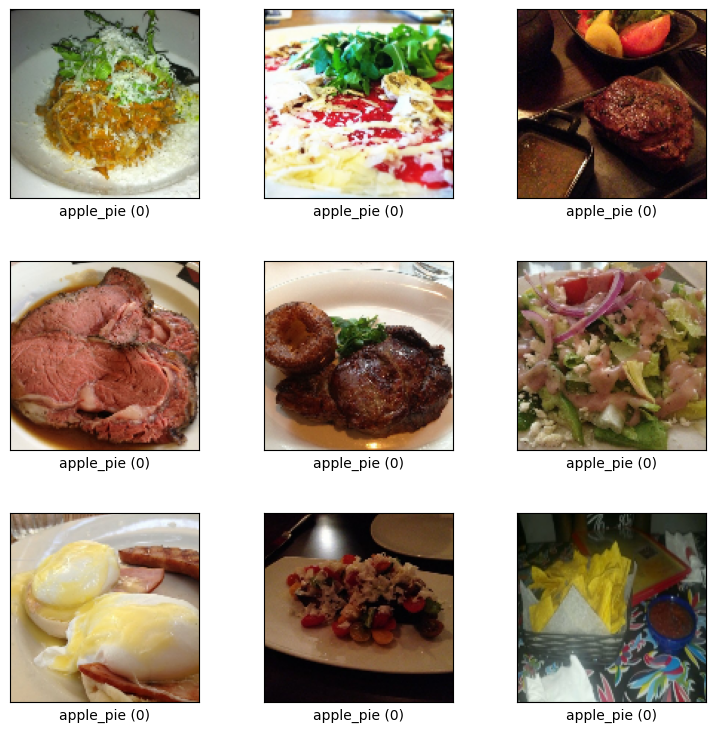

In [23]:
fig = tfds.show_examples(train_ds, ds_info)

In [24]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [25]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

In [27]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [31]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 81  83  92]
   [ 81  84  94]
   [ 80  85  96]
   ...
   [125 195 252]
   [118 191 249]
   [116 192 250]]

  [[144 168 190]
   [169 192 218]
   [141 163 193]
   ...
   [134 186 231]
   [133 186 233]
   [142 197 244]]

  [[ 69 109 173]
   [ 70 108 173]
   [ 59  97 161]
   ...
   [249 255 254]
   [247 254 254]
   [246 253 254]]

  ...

  [[ 58  56  70]
   [ 78  77  90]
   [ 61  59  73]
   ...
   [224 214 232]
   [233 222 240]
   [225 214 232]]

  [[ 67  70  88]
   [ 63  66  82]
   [ 72  71  87]
   ...
   [229 222 239]
   [228 220 237]
   [227 219 237]]

  [[166 175 201]
   [136 143 163]
   [ 79  84  96]
   ...
   [237 230 250]
   [232 229 248]
   [220 218 237]]]


 [[[ 90 104 102]
   [ 17  18  21]
   [ 87  89  89]
   ...
   [105  41  14]
   [109  45  18]
   [109  45  19]]

  [[ 91  94  96]
   [ 22   9  10]
   [ 48  38  33]
   ...
   [111  46  18]
   [113  48  19]
   [111  46  17]]

  [[ 13   9  11]
   [ 31  11   9]
   [ 50  32  23]
   ...
   [111  46  19]
   [108  43  15]


#Neural Network Implementation

In [38]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [45]:
for i, _ in ds['train'].take(1):
  image = i

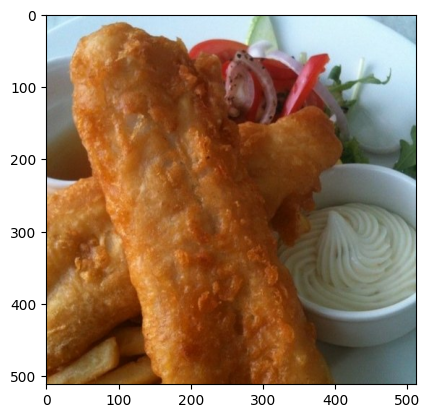

In [46]:
plt.imshow(image)

In [47]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

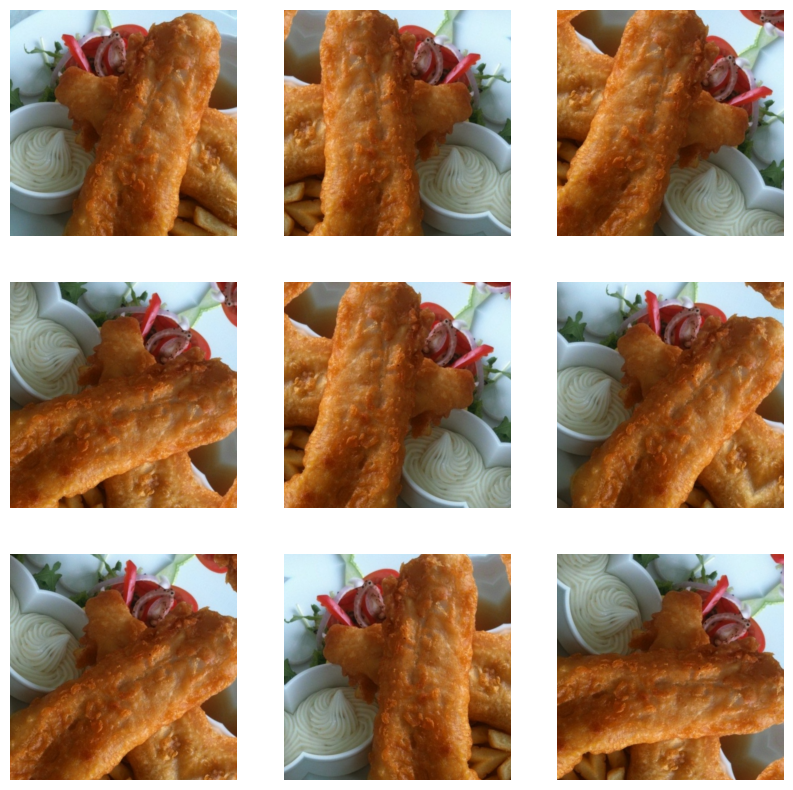

In [48]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [53]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [54]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 1.9964 - accuracy: 1.0000 - val_loss: 1.9971 - val_accuracy: 0.5168
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 1.6207 - accuracy: 1.0000 - val_loss: 2.0652 - val_accuracy: 0.5168
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 1.4664 - accuracy: 1.0000 - val_loss: 2.1819 - val_accuracy: 0.5168
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 1.3820 - accuracy: 1.0000 - val_loss: 2.3560 - val_accuracy: 0.5168
Epoch 5/50
1/1 [==============================] - 4s 4s/step - loss: 1.2917 - accuracy: 1.0000 - val_loss: 2.5760 - val_accuracy: 0.5168
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 1.2748 - accuracy: 1.0000 - val_loss: 2.8258 - val_accuracy: 0.5168
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 1.2685 - accuracy: 1.0000 - val_loss: 3.0956 - val_accuracy: 0.5168
Epoch 8/50
1/1 [=========================

In [56]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

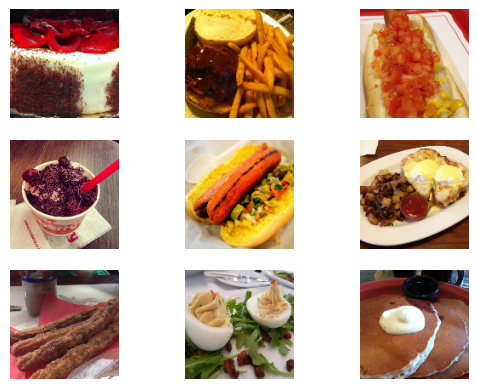

In [57]:
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.axis("off")

In [58]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int32)>